In [2]:
import haccytrees.mergertrees
import h5py
import math
import statspy
import scipy as sci
import numpy as np
import numpy.fft as fft # Is this supposed to be from scipy instead?
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter
from scipy.ndimage import gaussian_filter
%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees

pyfftw not available, using numpy fft


In [3]:
# Weird thing to do, since cosmic web is limited to LJSV
#forest, progenitor_array = haccytrees.mergertrees.read_forest('/data/a/cpac/mbuehlmann/LastJourney/forest/m000p.forest.000.hdf5',
#                                                              'LastJourney', nchunks=1, chunknum=0, mass_threshold = 2.7*10**11, include_fields = ["tree_node_mass", "snapnum", "fof_halo_tag", "sod_halo_cdelta"])

In [69]:
thresholds = [5*10**11]
thresholds_are_absolute = True
# Convert snapshots to redshifts -- opposite order (chronological)
redshifts = np.flip(np.array([10.044, 9.8065, 9.5789, 9.3608, 9.1515, 8.7573, 8.5714, 8.3925, 8.0541, 7.8938, 7.7391, 7.4454, 7.3058, 7.04, 6.9134, 6.6718, 6.5564, 6.3358, 6.1277, 6.028, 5.8367, 5.6556, 5.4839, 5.3208, 5.2422, 5.0909, 4.9467, 4.7429, 4.6145, 4.4918, 4.3743, 4.2618, 4.1015, 4.00, 3.8551, 3.763, 3.6313, 3.5475, 3.4273, 3.3133, 3.205, 3.102, 3.0361, 2.9412, 2.8506, 2.7361, 2.6545, 2.5765, 2.4775, 2.4068, 2.3168, 2.2524, 2.1703, 2.0923, 2.018, 1.9472, 1.8797, 1.7994, 1.7384, 1.68, 1.6104, 1.5443, 1.4938, 1.4334, 1.3759, 1.321, 1.2584, 1.2088, 1.152, 1.1069, 1.0552, 1.006, 0.9591, 0.9143, 0.8646, 0.824, 0.7788, 0.7358, 0.6948, 0.6557, 0.6184, 0.5777, 0.5391, 0.5022, 0.4714, 0.4337, 0.4017, 0.3636, 0.3347, 0.3035, 0.2705, 0.2423, 0.2123, 0.1837, 0.1538, 0.1279, 0.1008, 0.0749, 0.0502, 0.0245, 0.00]))

In [4]:
with h5py.File("/data/a/cpac/mbuehlmann/LJSV/maps/density.hdf5", "r") as f:
    delta = np.array(f['delta+1'], dtype=np.float64) - 1

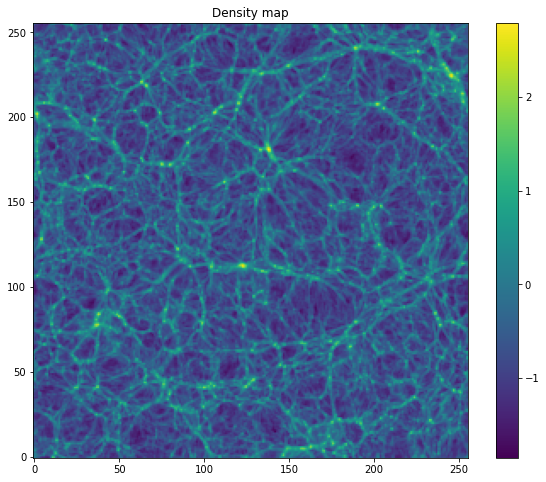

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
slice_n = 100
pcm = plt.imshow(np.log10(delta[:, :, slice_n]+1).T, cmap='viridis', origin = 'lower') # For some reason they are flipped over?
fig.colorbar(pcm)
ax.set_title("Density map")
fig.savefig("rho_slice_" + str(slice_n) + ".png")

In [6]:
print(delta.shape)
#delta

(256, 256, 256)


## Helper Functions

In [6]:
def smooth_f(f, sigma, N = 256, L = 250):
    ng = N # number of grid cells
    L = L # actual sidelength of subvolume, in Mpc/h
    xax = np.linspace(0, L, ng, endpoint = False) # Last entry will be ~249, at position i = 255
    dxax = L/ng # size of each interval (like a dx)
    x, y, z = np.meshgrid(xax, xax, xax, indexing='ij')
    # x, y, and z are like "d" above
    x[x > L/2] -= L
    y[y > L/2] -= L
    z[z > L/2] -= L
    g = 1/ ((2 * np.pi * sigma**2)**(3/2)) * np.exp(-( (x**2 + y**2 + z**2) / ( 2.0 * sigma**2 ) ) )
    fsmooth = fft.irfftn(fft.rfftn(f) * fft.rfftn(g*(dxax**3)))
    return fsmooth

In [1]:
def calculate_signatures(delta, threshold = -0.2, N = 256, L = 250):
    ng = N # mesh size
    rl = L # box size
    kx = fft.fftfreq(ng) * ng/rl * 2*math.pi
    ky = fft.fftfreq(ng) * ng/rl * 2*math.pi
    kz = fft.rfftfreq(ng) * ng/rl * 2*math.pi 

    kxgrid, kygrid, kzgrid = np.meshgrid(kx, ky, kz, indexing='ij')
    k_squared = kxgrid**2 + kygrid**2 + kzgrid**2
    k_squared[0,0,0] = 1

    delta_f = fft.rfftn(delta)
    phi = fft.irfftn(delta_f/-k_squared)
    
    Fx = fft.irfftn(1j * kxgrid * delta_f/ k_squared) # is this the same as fft.irfftn(1j * kxgrid * fft.rfftn(phi)) ?
    Fy = fft.irfftn(1j * kygrid * delta_f/ k_squared)
    Fz = fft.irfftn(1j * kzgrid * delta_f/ k_squared)
    
    Txx = fft.irfftn(-kxgrid * kxgrid * delta_f/ k_squared)
    Txy = fft.irfftn(-kxgrid * kygrid * delta_f/ k_squared)
    Txz = fft.irfftn(-kxgrid * kzgrid * delta_f/ k_squared)
    Tyy = fft.irfftn(-kygrid * kygrid * delta_f/ k_squared)
    Tyz = fft.irfftn(-kygrid * kzgrid * delta_f/ k_squared)
    Tzz = fft.irfftn(-kzgrid * kzgrid * delta_f/ k_squared)
    
    T = np.zeros((256, 256, 256, 3, 3))
    T[..., 0, 0] = Txx
    T[..., 0, 1] = Txy
    T[..., 0, 2] = Txz
    T[..., 1, 0] = Txy
    T[..., 1, 1] = Tyy
    T[..., 1, 2] = Tyz
    T[..., 2, 0] = Txz
    T[..., 2, 1] = Tyz
    T[..., 2, 2] = Tzz
    eigs = np.linalg.eigvalsh(T)
    print(eigs)
    # Find how many are positive, negative (translates to voids, nodes, etc.)
    mask = eigs > threshold
    signatures = np.sum(mask, axis=-1)
    isignatures = 3 - signatures # for plotting purposes
    
    return isignatures

## Implement

Text(0.5, 1.0, 'Smoothed density map: sigma = 10')

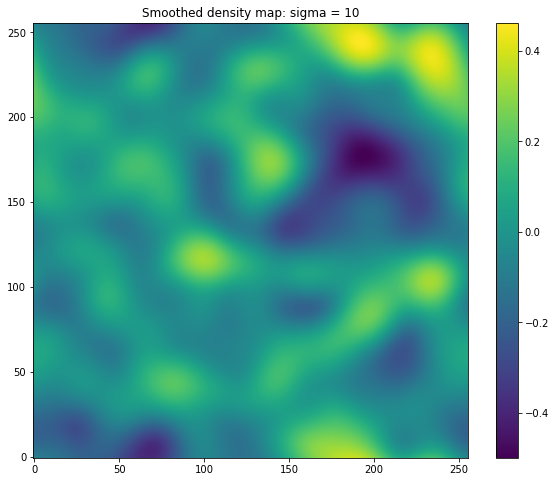

In [82]:
# Smooth the density field first
sigma = 10 # The way we define ax means we are in physical values, so sigma is in Mpc/h
delta_smooth = smooth_f(delta, sigma)
fig, ax = plt.subplots(figsize=(10, 8))
slice_n = 100
smooth_pcm = plt.imshow(np.log10(delta_smooth[:, :, slice_n]+1).T, cmap='viridis', origin = 'lower')
fig.colorbar(smooth_pcm)
ax.set_title("Smoothed density map: sigma = " + str(sigma))
#fig.savefig("delta_smooth_sigma" + str(sigma) + ".png")

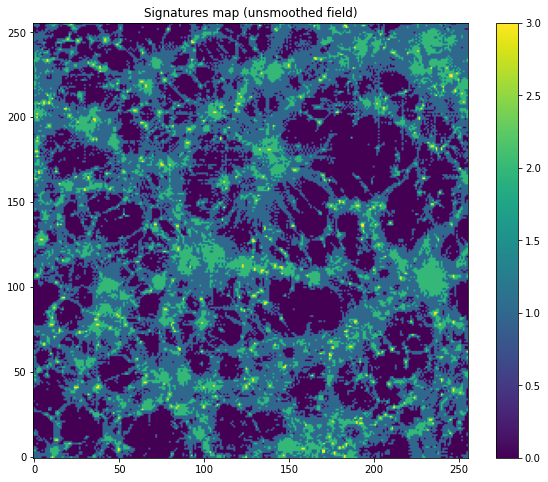

In [79]:
# Now, find signatures
my_threshold = -0.3
signatures_are_of_smooth_field = False
if signatures_are_of_smooth_field:
    smooth_sigs = calculate_signatures(delta_smooth, threshold = my_threshold)
else:
    smooth_sigs = calculate_signatures(delta, threshold = my_threshold)
fig, ax = plt.subplots(figsize=(10, 8))
pcm = plt.imshow(smooth_sigs[:, :, slice_n].T, cmap='viridis', vmin=0, vmax=3, origin = 'lower')
fig.colorbar(pcm)

if signatures_are_of_smooth_field:
    ax.set_title("Signatures map: sigma = " + str(sigma))
    #fig.savefig("delta_sigs_smooth_sigma" + str(sigma) + ".png")
else:
    ax.set_title("Signatures map (unsmoothed field)")
    #fig.savefig("delta_sigs_unsmoothed.png")

In [80]:
# Save
#func_name = "delta_sigs"
#fig.savefig(func_name + "_smooth_sigma" + str(sigma) + ".png")

# Validations

## Volume Fractions

Calculate the fractions of total volume that each environment takes up, and compare that to T-web in Table 2 of Libeskind 2017.

In [81]:
ev_names = ['voids', 'walls', 'filaments', 'nodes']
ev_counts = np.zeros(4)
evs, ev_counts = np.unique(smooth_sigs, return_counts=True)
ev_vol_fractions = ev_counts/np.sum(ev_counts)

print("Volume fractions, cell counts in each environment: ")
for i, name in enumerate(ev_names):
    print(name, ": ", ev_vol_fractions[i], ", ", ev_counts[i])

Volume fractions, cell counts in each environment: 
voids :  0.3907959461212158 ,  6556468
walls :  0.4575957655906677 ,  7677183
filaments :  0.14453279972076416 ,  2424858
nodes :  0.007075488567352295 ,  118707


## Environment Masks

Based on Libeskind (2017) Fig 4
- for each environment, create a mask that is True where we classified the volume as that env
- calculate the signatures from the smoothed density field, create the masks, apply the masks to the unsmoothed delta+1
- plot a histogram of log(delta+1)[mask] (the unsmoothed version!)

Remember, your signatures have been inversed. So the key for isignatures is opposite that for signatures. The key for isignatures is:
- void = 0
- wall = 1
- filament = 2
- node = 3

(which is the same as shown in the maps)

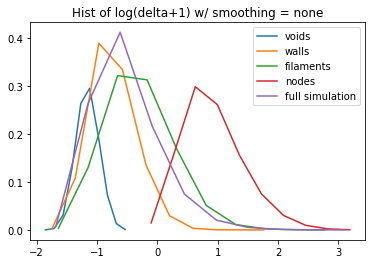

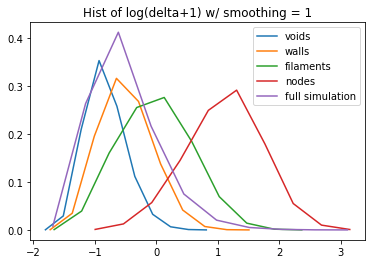

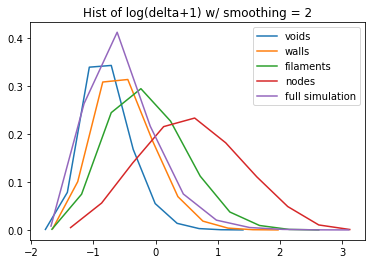

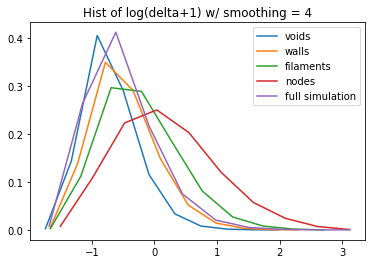

In [71]:
ev_nums = [0, 1, 2, 3] # voids, walls, filaments, nodes
ev_names = ['voids', 'walls', 'filaments', 'nodes', 'full simulation']
sigmas = ['none', 1, 2, 4]

# First, calculate sigs from the smoothed density field
smoothed_sigs = [calculate_signatures(delta)]
for sigma in sigmas[1:]:
    this_smoothed_delta = smooth_f(delta, sigma)
    these_smoothed_sigs = calculate_signatures(this_smoothed_delta, threshold = -0.2)
    smoothed_sigs.append(these_smoothed_sigs)

# Second, create the masks, and apply them to the unsmoothed delta+1
masked_deltas = []
for these_sigs in smoothed_sigs:
    a = []
    for ev_num in ev_nums:
        a.append(np.log10(delta+1)[these_sigs == ev_num])
    a.append(np.log10(delta+1).flatten())
    masked_deltas.append(a)

for i, masked_delta in enumerate(masked_deltas):
    fig, ax = plt.subplots()
    for j, this_delta in enumerate(masked_delta):
        hist = np.histogram(this_delta)
        norm_factor = len(this_delta)
        #print("for i: ", i, " and ev: ", ev_names[j], " count is: ", norm_factor)
        bin_centers = (hist[1][:-1] + hist[1][1:])/2
        ax.plot(bin_centers, hist[0]/norm_factor, label = ev_names[j])
        ax.legend()
    ax.set_title("Hist of log(delta+1) w/ smoothing = " + str(sigmas[i]))
    fig.savefig("hist_delta_by_ev_smoothing_" + str(sigmas[i]) + ".png")

# Old Stuff

In [ ]:
# Old, silly approach to validation
#for this_slice in smooth_sigs:
#    for this_row in this_slice:
#        for this_entry in this_row:
#            sig_counts[this_entry] += 1

#sig_counts = [np.sum(smooth_sigs==i) for i in range(4)]

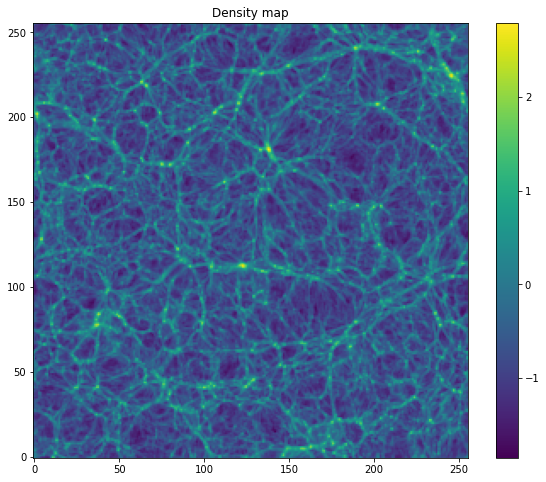

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
pcm = plt.imshow(np.log10(delta[:, :, 100]+1).T, cmap='viridis', origin = 'lower')
fig.colorbar(pcm)
ax.set_title("Density map")
fig.savefig("rho_slice_100.png")

# Old way
#fig, ax = plt.subplots(figsize=(10, 8))
#pcm = ax.pcolormesh(np.log10(delta[:, :, 100]+1).T) # Do the other plots also need to be log scale?
#fig.colorbar(pcm)

### Smoothing - Toy Problem

[[0.39894228 0.39894228 0.39894228 ... 0.39894228 0.39894228 0.39894228]
 [0.39732983 0.39732983 0.39732983 ... 0.39732983 0.39732983 0.39732983]
 [0.39253148 0.39253148 0.39253148 ... 0.39253148 0.39253148 0.39253148]
 ...
 [0.38466266 0.38466266 0.38466266 ... 0.38466266 0.38466266 0.38466266]
 [0.39253148 0.39253148 0.39253148 ... 0.39253148 0.39253148 0.39253148]
 [0.39732983 0.39732983 0.39732983 ... 0.39732983 0.39732983 0.39732983]]


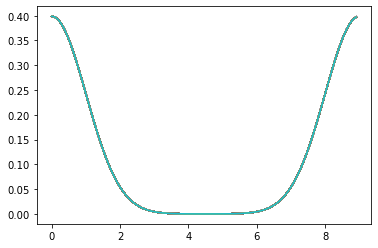

In [63]:
# Play around with meshgrids
ng = 100 # number of grid cells
L = 9 # actual sidelength of subvolume, in Mpc/h
ax = np.linspace(0, L, ng, endpoint = False)
#ax = np.linspace(-L/2, L/2, ng, endpoint = False) # This is wrong because we want coords to begin at (0,0)
x, y = np.meshgrid(ax, ax, indexing='ij')
x[x > L/2] -= L
sigma = 1
g = 1/ ((2 * np.pi * sigma**2)**(1/2)) * np.exp(-( ((x)**2) / ( 2.0 * sigma**2 ) ) ) # x - 4.05? Creates a weird roof...
plt.plot(ax, g)
print(g)

Should be 1:  1.000000000000002


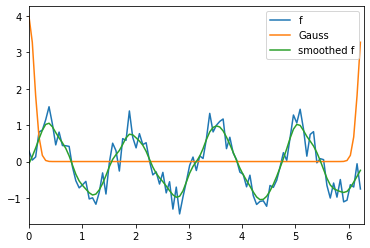

In [78]:
# Real-Space Manual Covolution:
# evaluate Integral[f(x'-x)g(x')dx'] at every x # Why that order of x' and x?
L = 2*np.pi
ng = 100
x = np.linspace(0, L, ng, endpoint=False)
dx = L/ng                               # the dx interval
d = np.copy(x)                          # the distance from origin (periodic)
d[d > L/2] -= L
f = np.sin(4*x) + np.random.normal(0, 0.3, size=x.shape)     # our function: sin + noise
sigma = 0.1
g = 1/(2*np.pi*sigma**2)**(1/2) * np.exp(-d**2/(2*sigma**2)) # gaussian kernel
print("Should be 1: ", np.sum(g*dx))
fsmooth = np.empty_like(f)
#for i in range(ng):
#    f_shift = np.roll(f, -i)            # This is all we need since function is periodic. What is f wasn't periodic?
    #g_shift = np.roll(g, i)
#    fsmooth[i] = np.sum(f_shift*g*dx)   # dx is small, so it scales down these values (?)
    #fsmooth[i] = np. sum(f*g_shift*dx)

# Fourier Space Multiplication
f_f = np.fft.rfft(f)*dx                  # Notice we multiply by dx every time
g_f = np.fft.rfft(g)*dx
fsmooth_f = f_f * g_f
fsmooth = np.fft.irfft(fsmooth_f) * 1/dx
# Or
#fsmooth = fft.irfftn(fft.rfftn(f) * fft.rfftn(g*dx)) # Notice the dx

# Analytic approach
#kx = fft.fftfreq(ng) * ng/L * 2*math.pi # or k = np.fft.rfftfreq(ng) * ng/L * 2*np.pi
#F_g = np.exp(-(sigma**2 * kx**2)/2)     # or g_f = np.exp(-k**2 * sigma**2 / 2)
#F_f = fft.fft(f)                        # or f_f = np.fft.rfft(f)
#fsmooth = fft.ifft(F_f * F_g)           # doesn't need dx anymore?

fig, ax = plt.subplots()
ax.plot(x, f, label='f')
ax.plot(x, g, label='Gauss')
ax.plot(x, fsmooth, label='smoothed f')
ax.set(xlim=(0, L))
ax.legend()
#fig.savefig("with_dx.png")

# Validate Results

## Volume Fractions

In [38]:
sig_counts = np.zeros(4)
a= [0, 2, 3, 0, 0, 2, 2, 2] # three, two, four, one
print(a)
print(sig_counts[a])
sig_counts[a] += 1
print(sig_counts)

[0, 2, 3, 0, 0, 2, 2, 2]
[0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 1. 1.]


In [16]:
print(range(256))

range(0, 256)
